# Reconstrucción del campo de flujo en una cavidad cuadrada
## TP N°1: Puntos de colocación
### Redes Neuronales Informadas por Física - Maestria en Inteligencia Artificial
#### Grupo N°4: Jorge Ceferino Valdez, Fabian Sarmiento y Trinidad Monreal.
---

Buscamos reconstruir el campo de flujo estacionario en una cavidad cuadrada usando una Red Neuronal Informada por Física (PINN). Se trata de resolver las ecuaciones de Navier-Stokes incomprensibles:

$$(\mathbf{u} \cdot \nabla)\mathbf{u} = -\nabla p + \frac{1}{Re} \nabla^2 \mathbf{u} \text{,  en Ω}$$

$$\nabla \cdot \mathbf{u} = 0 \text{,  en Ω}$$

con las siguientes condiciones de borde:

- _No-slip_ en las fronteras laterales e inferior ($\mathbf{u} = (0,0)$)
- Velocidad constante en direccion $+x$ en la frontera superior ($\mathbf{u} = (1,0)$)

y $Ω = [0,1]⊗[0,1]$

Definimos 3 tipos de puntos:
- PDE points ($𝑁_{pde}$ = 1000): donde se evaluarán los residuos de la ecuación de Navier-Stokes.
- BC points ($𝑁_{bc}$ = 100): donde se evaluarán las condiciones de borde.
- Labeled data points (Ndata = 10): con datos de presión y velocidad conocidos (no constituyen específicamente “puntos de colocación”).

### 1. Definición de los sub-conjuntos de puntos de colocación

_Definir los sub-conjuntos de puntos de colocación según el tipo de residuo que deberían incluir en la función de pérdida, y teniendo en cuenta la configuración geométrica del problema. Utilizar $𝑁_{pde}$ = 1000 y $𝑁_{bc}$ = 100. Implementar estrategias de muestreo tipo grillas regulares y muestreo aleatorio._

#### Generamos puntos PDE (interior del dominio)

Usamos dos estrategias:
- Grilla regular
- Muestreo aleatorio uniforme

In [1]:
import torch
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(1)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Parámetros
N_pde = 1000
N_bc = 100

# Grilla regular para PDE
nx = 25
ny = 40
x_grid = torch.linspace(0, 1, nx, device=device)
y_grid = torch.linspace(0, 1, ny, device=device)
Xg, Yg = torch.meshgrid(x_grid, y_grid, indexing='ij')
pde_points_grid = torch.stack([Xg.reshape(-1), Yg.reshape(-1)], dim=1)

# Muestreo aleatorio uniforme
x_rand = torch.rand(N_pde, device=device)
y_rand = torch.rand(N_pde, device=device)
pde_points_rand = torch.stack([x_rand, y_rand], dim=1)

print(f"Puntos solicitados: {N_pde}")
print(f"Puntos generados grilla regular: {nx*ny}")
print(f"Puntos generados aleatorios: {pde_points_rand.shape[0]}")

Puntos solicitados: 1000
Puntos generados grilla regular: 1000
Puntos generados aleatorios: 1000


#### Generamos puntos BC (frontera del dominio)

Usamos dos estrategias:
- Grilla regular
- Muestreo aleatorio uniforme

In [2]:
N_each = N_bc // 4  # 25 por cada borde

# Grilla regular
x_bottom = torch.linspace(0, 1, N_each, device=device)
y_bottom = torch.zeros(N_each, device=device)
bottom = torch.stack([x_bottom, y_bottom], dim=1)

x_top = torch.linspace(0, 1, N_each, device=device)
y_top = torch.ones(N_each, device=device)
top = torch.stack([x_top, y_top], dim=1)

y_left = torch.linspace(0, 1, N_each, device=device)
x_left = torch.zeros(N_each, device=device)
left = torch.stack([x_left, y_left], dim=1)

y_right = torch.linspace(0, 1, N_each, device=device)
x_right = torch.ones(N_each, device=device)
right = torch.stack([x_right, y_right], dim=1)

bc_points_grid = torch.cat([bottom, top, left, right], dim=0)

# Muestreo aleatorio
x_bottom_rand = torch.rand(N_each, device=device)
y_bottom_rand = torch.zeros(N_each, device=device)
bottom_rand = torch.stack([x_bottom_rand, y_bottom_rand], dim=1)

x_top_rand = torch.rand(N_each, device=device)
y_top_rand = torch.ones(N_each, device=device)
top_rand = torch.stack([x_top_rand, y_top_rand], dim=1)

y_left_rand = torch.rand(N_each, device=device)
x_left_rand = torch.zeros(N_each, device=device)
left_rand = torch.stack([x_left_rand, y_left_rand], dim=1)

y_right_rand = torch.rand(N_each, device=device)
x_right_rand = torch.ones(N_each, device=device)
right_rand = torch.stack([x_right_rand, y_right_rand], dim=1)

bc_points_rand = torch.cat([bottom_rand, top_rand, left_rand, right_rand], dim=0)

### 2. Graficar los puntos de colocación. Emplear un color distinto según el subconjunto al que pertenecen.

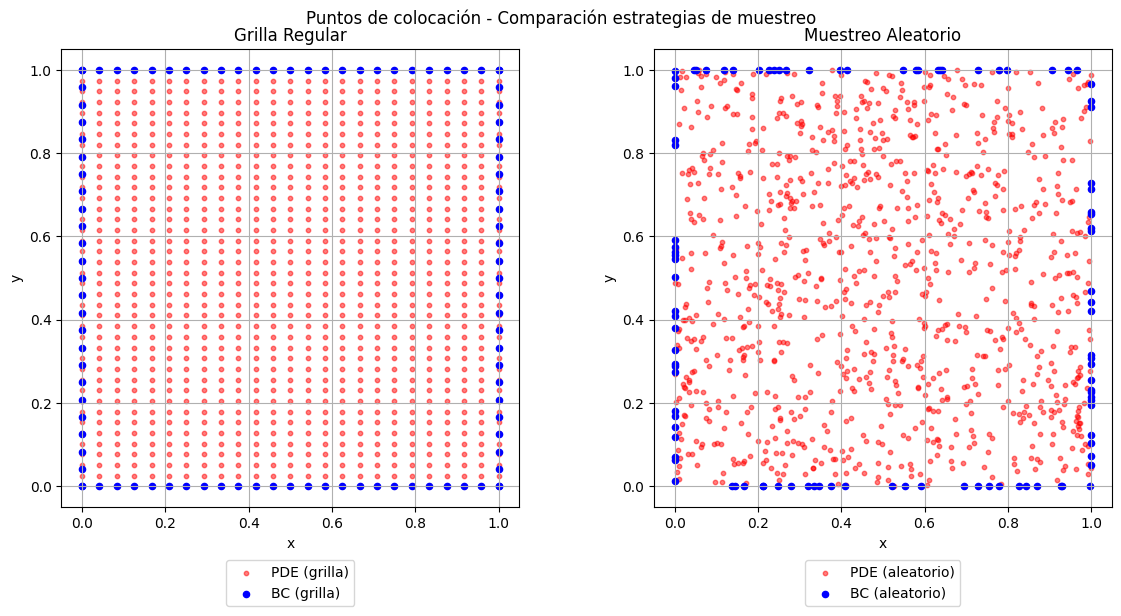

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Grilla regular
ax[0].scatter(*pde_points_grid.T.cpu().numpy(), s=10, c='red', alpha=0.5, label='PDE (grilla)')
ax[0].scatter(*bc_points_grid.T.cpu().numpy(), s=20, c='blue', label='BC (grilla)')
ax[0].set_title('Grilla Regular')
ax[0].axis('square')
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1))
ax[0].grid(True)

# Muestreo aleatorio
ax[1].scatter(*pde_points_rand.T.cpu().numpy(), s=10, c='red', alpha=0.5, label='PDE (aleatorio)')
ax[1].scatter(*bc_points_rand.T.cpu().numpy(), s=20, c='blue', label='BC (aleatorio)')
ax[1].set_title('Muestreo Aleatorio')
ax[1].axis('square')
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1))
ax[1].grid(True)

for a in ax:
    a.set_xlabel("x")
    a.set_ylabel("y")

plt.suptitle("Puntos de colocación - Comparación estrategias de muestreo")
plt.tight_layout()
plt.show()


Si bien la grilla asegura una cobertura homogénea del dominio y los bordes, el muestreo aleatorio introduce variabilidad que puede favorecer la generalización del modelo, aunque puede dejar zonas mal cubiertas.

### 3. Inclusión de datos rotulados
_Considere la existencia de $𝑁_{data}$ = 10 puntos (𝑥, 𝑦) en el domino (no constituyen específicamente “puntos de colocación”) sobre los que se cuenta con mediciones de presión 𝑝 y velocidades (𝑢, 𝑣), distribuidos de forma aleatoria. Construya el dataset correspondiente, incluyendo los labels (para ello, utilice los datos de presión y velocidad suministrados). ¿Qué le sugiere la estructura de datos de este dataset complementario respecto a los sub-conjuntos de puntos de colocación, en relación con los labels?_

In [4]:
from scipy.io import loadmat

# Cargar archivos
pressure_mat = loadmat('Re-100/pressure.mat')
velocity_mat = loadmat('Re-100/velocity.mat')

print("Claves en pressure.mat:", pressure_mat.keys())
print("Claves en velocity.mat:", velocity_mat.keys())

Claves en pressure.mat: dict_keys(['__header__', '__version__', '__globals__', 'x', 'y', 'z', 'p'])
Claves en velocity.mat: dict_keys(['__header__', '__version__', '__globals__', 'x', 'y', 'z', 'u', 'v', 'w'])


In [5]:
# Extraer arrays relevantes
p_array = pressure_mat['p']               
u_array = velocity_mat['u']               
v_array = velocity_mat['v']              

# Convertir a tensores y mover al device
p_tensor = torch.tensor(p_array, dtype=torch.float32, device=device)
u_tensor = torch.tensor(u_array, dtype=torch.float32, device=device)
v_tensor = torch.tensor(v_array, dtype=torch.float32, device=device)

# Tamaño de grilla
ny, nx = p_tensor.shape
print(f"Grid size: nx={nx}, ny={ny}")

Grid size: nx=20201, ny=1


Generamos 10 puntos (x,y) aleatorios y obtenemos los labels

In [6]:
N_data = 10

# Muestreamos 10 puntos aleatorios
x_data = torch.rand(N_data, device=device)
y_data = torch.rand(N_data, device=device)
data_points = torch.stack([x_data, y_data], dim=1)

# Mapeamos cada (x, y) a su índice en la malla
idx = torch.clamp((x_data * (nx - 1)).long(), 0, nx - 1)
idy = torch.clamp((y_data * (ny - 1)).long(), 0, ny - 1)

# Extraemos u, v y p
p_vals = p_tensor[idy, idx]
u_vals = u_tensor[idy, idx]
v_vals = v_tensor[idy, idx]

labels = torch.stack([u_vals, v_vals, p_vals], dim=1)  

Construimos dataset correspondiente

In [7]:
from torch.utils.data import TensorDataset

labeled_dataset = TensorDataset(data_points, labels)

In [8]:
import pandas as pd
import numpy as np

# Visualizamos dataset con dataframe
coords = labeled_dataset.tensors[0].cpu().numpy()  # (x, y)
labels = labeled_dataset.tensors[1].cpu().numpy()  # (u, v, p)

df = pd.DataFrame(
    data = np.hstack([coords, labels]),
    columns = ['x', 'y', 'u', 'v', 'p']
)
df.head(10)

,x,y,u,v,p
0,0.225482,0.358360,-0.018711,0.102659,-0.011602
1,0.583544,0.298718,-0.012905,-0.014866,0.004125
2,0.436371,0.329300,0.071970,0.153073,-0.048072
3,0.567724,0.396957,-0.053347,-0.016601,0.005544
4,0.070219,0.635064,-0.001669,0.004449,0.001132
5,0.980570,0.414920,0.100222,0.161373,-0.182337
6,0.563710,0.253440,-0.009847,-0.008861,0.004785
7,0.000295,0.801332,0.000000,0.000000,-0.000257
8,0.548126,0.278513,-0.029551,-0.008844,0.006288
9,0.972664,0.966565,0.620577,0.019744,-0.060107


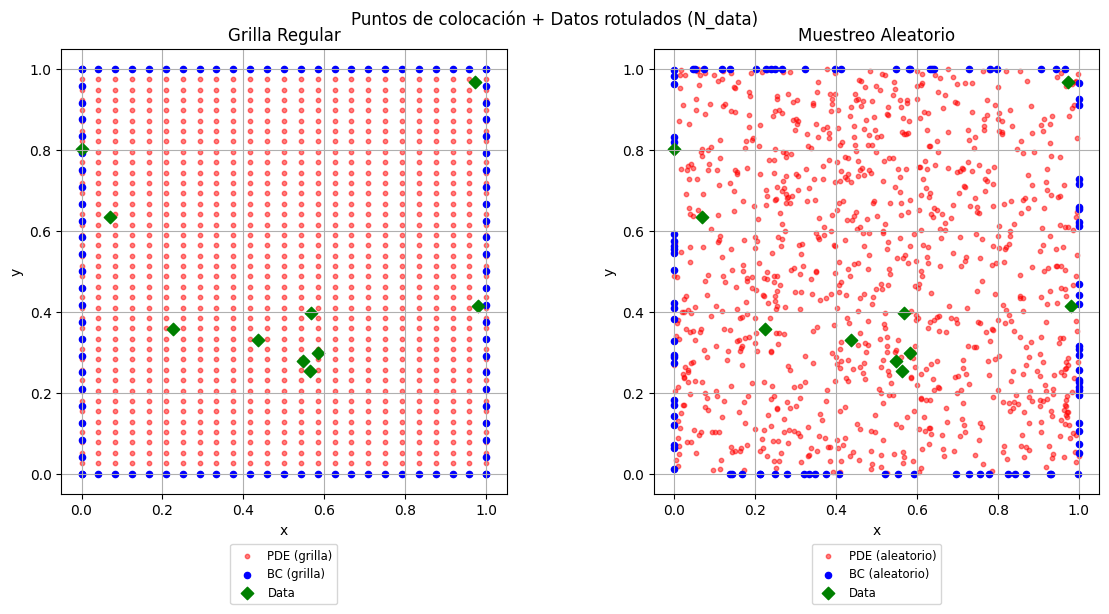

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Grilla regular
ax[0].scatter(*pde_points_grid.T.cpu().numpy(), s=10, c='red', alpha=0.5, label='PDE (grilla)')
ax[0].scatter(*bc_points_grid.T.cpu().numpy(), s=20, c='blue', label='BC (grilla)')
ax[0].scatter(x_data.cpu().numpy(), y_data.cpu().numpy(), s=40, c='green', marker='D', label='Data')
ax[0].set_title('Grilla Regular')
ax[0].axis('square')
ax[0].grid(True)

# Muestreo aleatorio
ax[1].scatter(*pde_points_rand.T.cpu().numpy(), s=10, c='red', alpha=0.5, label='PDE (aleatorio)')
ax[1].scatter(*bc_points_rand.T.cpu().numpy(), s=20, c='blue', label='BC (aleatorio)')
ax[1].scatter(x_data.cpu().numpy(), y_data.cpu().numpy(), s=40, c='green', marker='D', label='Data')
ax[1].set_title('Muestreo Aleatorio')
ax[1].axis('square')
ax[1].grid(True)

# Etiquetas y leyendas
for a in ax:
    a.set_xlabel("x")
    a.set_ylabel("y")
    a.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fontsize='small')

plt.suptitle("Puntos de colocación + Datos rotulados (N_data)")
plt.tight_layout()
plt.show()

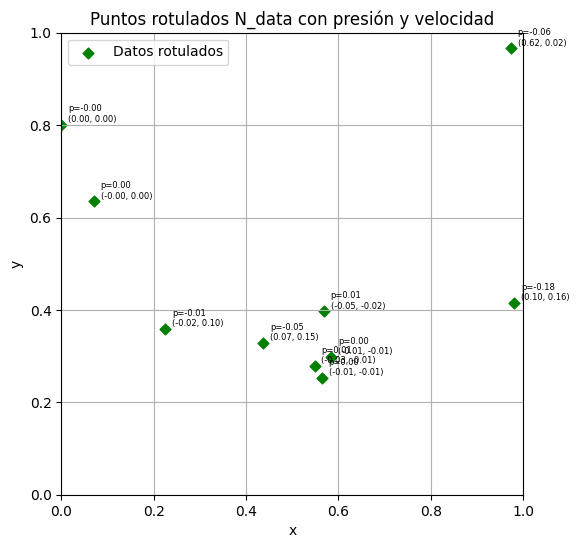

In [10]:
plt.figure(figsize=(6, 6))

plt.scatter(x_data.cpu().numpy(), y_data.cpu().numpy(), color='green', s=30, marker='D', label='Datos rotulados')

for i in range(N_data):
    x = x_data[i].cpu().item()
    y = y_data[i].cpu().item()
    u = labels[i, 0].item()
    v = labels[i, 1].item()
    p = labels[i, 2].item()
    label_str = f"p={p:.2f}\n({u:.2f}, {v:.2f})"
    plt.annotate(label_str, (x, y), textcoords="offset points", xytext=(5, 2), fontsize=6)

plt.title("Puntos rotulados N_data con presión y velocidad")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.axis("square")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

A diferencia de los puntos de colocación utilizados para imponer restricciones físicas (PDE y condiciones de borde), los puntos del dataset rotulado incluyen directamente los valores conocidos de presión y velocidad. Esta estructura complementaria permite entrenar el modelo en un enfoque semi-supervisado o gray-box, en el que la red no solo aprende a cumplir las ecuaciones de Navier-Stokes, sino también a ajustarse a datos reales. Esto mejora la precisión local del modelo en regiones específicas del dominio.

En el gráfico se observa que los puntos $N_{data}$ están distribuidos en el interior del dominio, pero no coinciden con los nodos de la grilla. Esto refleja su naturaleza "complementaria", ya que no son puntos de colocación tradicionales sino instancias específicas donde se conoce la solución y se puede supervisar el aprendizaje.

### 4. Para pensar: el sub-conjunto de los puntos de colocación correspondientes a la PDE de la ecuación de gobierno, ¿debería o no contener puntos definidos sobre las fronteras físicas del dominio?

En general, los puntos de colocación asociados a la PDE deben ubicarse en el interior del dominio, ya que allí es donde se espera que se cumpla la ecuación de gobierno (Navier-Stokes). Las fronteras están regidas por condiciones de contorno específicas, por lo tanto deben tratarse por separado mediante puntos BC. Incluir puntos de PDE sobre el borde podria introducir redundancias o conflictos si no se manejan cuidadosamente.